## Zoo Pokedex Part 2 Oryxes vs Llamas

In [20]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [21]:
PATH = "data/"
sz=224
batch_size=64

In [22]:
from keras.models import load_model
from keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np
import os
from keras.applications import imagenet_utils



In [23]:
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.layers import Dropout, Flatten, Dense
from keras.applications import ResNet50
from keras.models import Model, Sequential
from keras.layers import Dense, GlobalAveragePooling2D
from keras import backend as K
from keras.applications.resnet50 import preprocess_input

In [6]:
train_data_dir = f'{PATH}train'
validation_data_dir = f'{PATH}valid'

# Image Data tranformation generators

In [7]:
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
    shear_range=0.2, zoom_range=0.2, horizontal_flip=True)

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(train_data_dir,
    target_size=(sz, sz),
    batch_size=batch_size, class_mode='binary')

validation_generator = test_datagen.flow_from_directory(validation_data_dir,
    shuffle=True,
    target_size=(sz, sz),
    batch_size=batch_size, class_mode='binary')

Found 189 images belonging to 2 classes.
Found 106 images belonging to 2 classes.


# Showing image data transformations

In [32]:
img = load_img('data/train/alpaka/Alpacca1.jpg')
x = img_to_array(img)  # this is a Numpy array with shape (3, 150, 150)
x = x.reshape((1,) + x.shape)  # this is a Numpy array with shape (1, 3, 150, 150)
i = 0
for batch in train_datagen.flow(x, batch_size=1,
                          save_to_dir='preview', save_prefix='alpacca', save_format='jpeg'):
    i += 1
    if i > 20:
        break  # otherwise the generator would loop indefinitely

# Base Model

In [119]:
base_model = ResNet50(weights='imagenet')

# Changed model

In [34]:
base_model = ResNet50(weights='imagenet', include_top=False)
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)

In [38]:
from keras import optimizers
optimizer = optimizers.RMSprop(lr=0.00001, rho=0.9, epsilon=None, decay=0.0)
#optimizers.SGD(lr=1e-4, momentum=0.9)

In [39]:
model = Model(inputs=base_model.input, outputs=predictions)
for layer in base_model.layers: layer.trainable = False
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

In [40]:
%%time
model.fit_generator(train_generator, train_generator.n // batch_size, epochs=3, workers=4,
        validation_data=validation_generator, validation_steps=validation_generator.n // batch_size)

Epoch 1/3
2/2 [==============================] - 51s 26s/step - loss: 0.7053 - acc: 0.5605 - val_loss: 0.6473 - val_acc: 0.6094
Epoch 2/3
2/2 [==============================] - 49s 25s/step - loss: 0.6485 - acc: 0.6094 - val_loss: 0.5948 - val_acc: 0.7031
Epoch 3/3
2/2 [==============================] - 50s 25s/step - loss: 0.5661 - acc: 0.7436 - val_loss: 0.5598 - val_acc: 0.7188
CPU times: user 12min 58s, sys: 54.5 s, total: 13min 52s
Wall time: 2min 30s


### Freeze layers and train final one

In [41]:
split_at = 140
for layer in model.layers[:split_at]: layer.trainable = False
for layer in model.layers[split_at:]: layer.trainable = True
#model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])    
model.compile(optimizer=optimizers.RMSprop(lr=0.00001, rho=0.9, epsilon=None, decay=0.0), loss='binary_crossentropy', metrics=['accuracy'])    

In [42]:
%%time
model.fit_generator(train_generator, train_generator.n // batch_size, epochs=1, workers=3,
        validation_data=validation_generator, validation_steps=validation_generator.n // batch_size)

Epoch 1/1
2/2 [==============================] - 60s 30s/step - loss: 0.5150 - acc: 0.7891 - val_loss: 0.4638 - val_acc: 0.8281
CPU times: user 4min 36s, sys: 21.8 s, total: 4min 58s
Wall time: 1min 1s


# Predict single Images

In [193]:

def load_image(img_path, show=False):

    img = image.load_img(img_path, target_size=(224, 224))
    img_tensor = image.img_to_array(img)                    # (height, width, channels)
    img_tensor = np.expand_dims(img_tensor, axis=0)         # (1, height, width, channels), add a dimension because the model expects this shape: (batch_size, height, width, channels)
    #img_tensor /= 255.                                      # imshow expects values in the range [0, 1]

    if show:
        plt.imshow(img_tensor[0]/255)                           
        plt.axis('off')
        plt.show()

    return img_tensor

In [194]:
#r = prepare_image("data/valid/oryx/106.jpg",224)

In [46]:
  img = image.load_img("data/valid/oryx/106.jpg")

In [48]:
image.img_to_array(img).shape

(1200, 1600, 3)

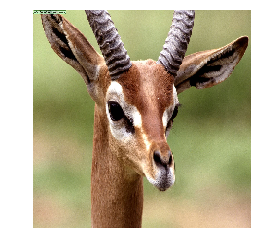

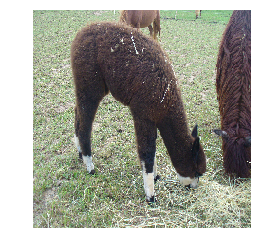

In [195]:
oryx = load_image("data/valid/oryx/106.jpg", show=True)
alpaka = load_image("data/valid/alpaka/Alpacca102.jpg", show=True)

In [196]:
model.predict(alpaka)

array([[0.41329405]], dtype=float32)

In [197]:
model.predict(oryx)

array([[0.61466146]], dtype=float32)

# Evaluate

In [49]:
from sklearn.metrics import confusion_matrix
r = next(validation_generator)
probs = model.predict(r[0])
classes = []
for prob in probs:
    if prob < 0.5:
        classes.append(0)
    else:
        classes.append(1)
cm = confusion_matrix(classes, r[1])
cm

array([[15,  2],
       [ 8, 17]])